# Imports

In [1]:
# Freqtrade Workspace

# Notebook Helper
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

# Standard Imports
from pathlib import Path
from typing import List, Callable, Tuple, Any
from wandb.wandb_run import Run
from datetime import datetime, timedelta
from functools import reduce
import attr
import gc
import os
import wandb
import nest_asyncio
import logging
import sys
import pandas as pd
import numpy as np
import mplfinance as mpf
import pandas_ta as pta
import talib.abstract as ta
import random

# Resolve CWD
gc.collect()
nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.ml.lightning import LightningModule, LightningConfig
from freqtrade.ml.trainer import TradingTrainer
from freqtrade.ml.container import LightningContainer
from freqtrade.ml import loader, lightning_utils
from freqtrade.nbtools.preset import LocalPreset, ConfigPreset, FilePreset, CloudPreset
from freqtrade.nbtools.backtest import backtest
from freqtrade.nbtools import plotting, configs
from freqtrade.nbtools.helper import free_mem
from freqtrade.nbtools.pairs import PAIRS_HIGHCAP_NONSTABLE

import freqtrade.vendor.qtpylib.indicators as qtpylib

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
PATH_DATA = PATH_MOUNT / "data"
PATH_PRESETS = PATH_MOUNT / "presets"
PATH_STRATEGIES = PATH_PRESETS / ".strategy_files"

# Define custom functions
def get_random_index(dataframe: pd.DataFrame, loc_condition):
    idx = 0
    while idx < 100 or idx > len(dataframe) - 100:
        idx = dataframe.loc[loc_condition].sample()["idx"][0]
    return idx


def get_middle(dataframe: pd.DataFrame, index: int, num_look: int) -> pd.DataFrame:
    return dataframe.loc[
        (dataframe["idx"] >= index - num_look) & (dataframe["idx"] <= index + num_look)
    ]


style = {'base_mpl_style': 'fast',
         'marketcolors'  : {'candle': {'up': '#00b060', 'down': '#fe3032'},
                            'edge'  : {'up': '#00b060', 'down': '#fe3032'},
                            'wick'  : {'up': '#606060', 'down': '#606060'},
                            'ohlc'  : {'up': '#00b060', 'down': '#fe3032'},
                            'volume': {'up': '#4dc790', 'down': '#fd6b6c'},
                            'vcedge': {'up': '#1f77b4', 'down': '#1f77b4'},
         'vcdopcod'      : True,
         'alpha'         : 0.9},
         'mavcolors'     : None,
         'facecolor'     : '#fafafa',
         'gridcolor'     : '#d0d0d0',
         'gridstyle'     : '-',
         'y_on_right'    : True,
         'rc'            : {'axes.labelcolor': '#101010',
                            'axes.grid.axis' : 'y',
                            'ytick.color'    : '#101010',
                            'xtick.color'    : '#101010',
                            'figure.titlesize': 'x-large',
                            'figure.titleweight':'semibold',
                            'axes.edgecolor'  : 'black',
                           'axes.linewidth'  :  1.0,
                           'lines.linewidth' :  1.0,
                           },
         'base_mpf_style': 'yahoo'}


def plot(dataframe: pd.DataFrame, display_indicators: dict, draw_signals: bool, length = 150):
    """ Plot the price chart!
    """
    df = dataframe.copy()[-length:]
    
    addplot = []
    kwargs = {}
    
    if draw_signals:
        df.loc[df["buy"] == 1, "buy"] = df["low"] - (0.0025*df["low"])
        df.loc[df["buy"] == 0, "buy"] = np.nan
        df.loc[df["sell"] == 1, "sell"] = df["high"] + (0.0025*df["high"])
        df.loc[df["sell"] == 0, "sell"] = np.nan
        
        # Add buy and sell markers
        if len(df.loc[df["buy"] > 0]) > 0: 
            addplot.append(mpf.make_addplot(df["buy"], type='scatter', markersize=100, marker='^', color="green"))
        if len(df.loc[df["sell"] > 0]) > 0: 
            addplot.append(mpf.make_addplot(df["sell"], type='scatter', markersize=100, marker='v', color="red"))
    
        # Add vline markers
        df.index = pd.to_datetime(df.index)
        kwargs["vlines"] = {
            "vlines": list(df.loc[df["buy"] > 0].index) + list(df.loc[df["sell"] > 0].index),
            "alpha": 0.25,
            "colors": ["green" for _ in range(len(df.loc[df["buy"] > 0]))] + ["red" for _ in range(len(df.loc[df["sell"] > 0]))]
        }
    
    for indicator, opt in display_indicators.items():
        _kwargs = {}
        
        if opt["type"] != "line":
            _kwargs["type"] = opt["type"]
        
        plot = mpf.make_addplot(
            df[indicator], 
            color=opt["color"], 
            panel=opt["panel"], 
            ylabel=indicator, 
            **_kwargs
        )
        
        addplot.append(plot)
    
    mpf.plot(
        df, 
        type="candle", 
        style=style, 
        figsize=(15, 8), 
        addplot=addplot,
        **kwargs,
    )
    
def process_df_pop(_df_pop: pd.DataFrame) -> pd.DataFrame:
    len_buy, len_sell = len(_df_pop.loc[_df_pop["buy"] == 1]), len(_df_pop.loc[_df_pop["sell"] == 1])
    print(f"Buy signals: {len_buy} | Sell signals: {len_sell}")
    if len_buy == 0: raise Exception("Zero BUY signals")
    if len_sell == 0: raise Exception("Zero SELL signals")
    idx_buy, idx_sell = get_random_index(_df_pop, _df_pop["buy"] == 1), get_random_index(_df_pop, _df_pop["sell"] == 1)
    print(f"Index BUY: {idx_buy} | Index SELL: {idx_sell}")
    look_len = 70
    if random.randint(0, 1) == 0: 
        print("Showing SELL example")
        df_middle = get_middle(_df_pop, idx_sell, look_len)
    else:
        print("Showing BUY example")
        df_middle = get_middle(_df_pop, idx_buy, look_len)
    return df_middle
    

env: WANDB_SILENT=true


# Build Any Strategy

In [3]:
timeframe = "4h"
df_load = loader.load_df(PATH_DATA / "binance"/ f"BTC_USDT-{timeframe}.json", timeframe).iloc[-100000:]
df_load = df_load.set_index("date")
df_load["idx"] = range(0, len(df_load))
df_load["buy"] = 0
df_load["sell"] = 0
df_load

,open,high,low,close,volume,idx,buy,sell
date,,,,,,,,
2017-08-17 04:00:00+00:00,4261.48,4349.99,4261.32,4349.99,82.088865,0,0,0
2017-08-17 08:00:00+00:00,4333.32,4485.39,4333.32,4427.30,63.619882,1,0,0
2017-08-17 12:00:00+00:00,4436.06,4485.39,4333.42,4352.34,174.562001,2,0,0
2017-08-17 16:00:00+00:00,4352.33,4354.84,4200.74,4325.23,225.109716,3,0,0
2017-08-17 20:00:00+00:00,4307.56,4369.69,4258.56,4285.08,249.769913,4,0,0
...,...,...,...,...,...,...,...,...
2021-09-01 00:00:00+00:00,47100.89,47321.42,46512.00,47043.65,7128.979580,8855,0,0
2021-09-01 04:00:00+00:00,47043.65,47473.28,46969.56,47171.01,6205.347520,8856,0,0
2021-09-01 08:00:00+00:00,47171.00,47770.00,47111.25,47713.31,7612.408370,8857,0,0


# Strategy Signal Visualization

In [3]:
def populate_indicators(dataframe: pd.DataFrame) -> pd.DataFrame:
    """ Populate Freqtrade Indicators """
    dataframe["dema"] = pta.dema(dataframe["close"], length=1000)
    supertrend = pta.supertrend(
        high=dataframe["high"], low=dataframe["low"], close=dataframe["close"], length=12, multiplier=3
    )
    dataframe[supertrend.columns] = supertrend
    return dataframe


def populate_buy_trend(dataframe: pd.DataFrame) -> pd.DataFrame:
    """ Generate BUY Signals"""
    conditions = [
        # Trigger
        (
            qtpylib.crossed_above(dataframe["close"], dataframe["SUPERT_12_3.0"])
        ),
        # Filter
        dataframe["close"] > dataframe['dema'],
        dataframe['volume'] > 0,
    ]
            
    dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
    return dataframe

    
def populate_sell_trend(dataframe: pd.DataFrame) -> pd.DataFrame:
    """ Generate SELL Signals"""
    conditions = [
        qtpylib.crossed_below(dataframe["close"], dataframe["SUPERT_12_3.0"]),
        dataframe['volume'] > 0,
    ]
            
    dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
    return dataframe


df_pop = populate_sell_trend(populate_buy_trend(populate_indicators(df_load.copy())))
df_pop

,open,high,low,close,volume,idx,buy,sell,dema,SUPERT_12_3.0,SUPERTd_12_3.0,SUPERTl_12_3.0,SUPERTs_12_3.0
date,,,,,,,,,,,,,
2017-08-17 04:00:00+00:00,4261.48,4349.99,4261.32,4349.99,82.088865,0,0,0,NaN,0.00000,1,NaN,NaN
2017-08-17 08:00:00+00:00,4333.32,4485.39,4333.32,4427.30,63.619882,1,0,0,NaN,NaN,1,NaN,NaN
2017-08-17 12:00:00+00:00,4436.06,4485.39,4333.42,4352.34,174.562001,2,0,0,NaN,NaN,1,NaN,NaN
2017-08-17 16:00:00+00:00,4352.33,4354.84,4200.74,4325.23,225.109716,3,0,0,NaN,NaN,1,NaN,NaN
2017-08-17 20:00:00+00:00,4307.56,4369.69,4258.56,4285.08,249.769913,4,0,0,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01 00:00:00+00:00,47100.89,47321.42,46512.00,47043.65,7128.979580,8855,0,0,44568.488155,49389.91034,-1,NaN,49389.91034
2021-09-01 04:00:00+00:00,47043.65,47473.28,46969.56,47171.01,6205.347520,8856,0,0,44585.474791,49389.91034,-1,NaN,49389.91034
2021-09-01 08:00:00+00:00,47171.00,47770.00,47111.25,47713.31,7612.408370,8857,0,0,44604.568805,49389.91034,-1,NaN,49389.91034


Buy signals: 40 | Sell signals: 94
Index BUY: 2439 | Index SELL: 1855
Showing BUY example


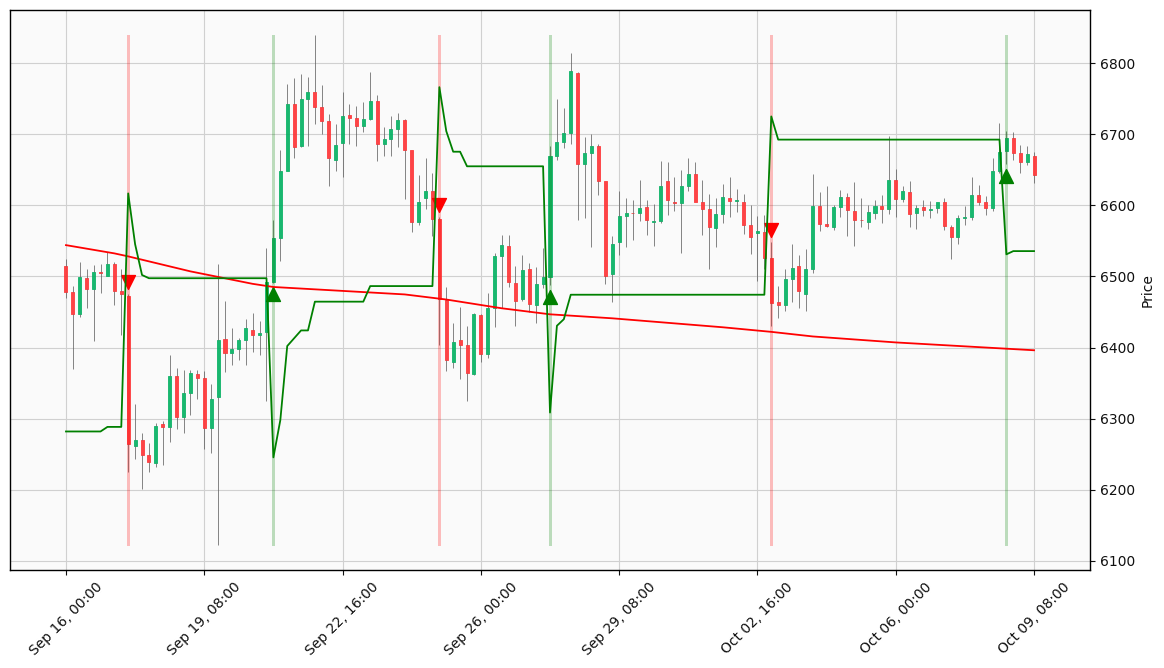

In [4]:
df_middle = process_df_pop(df_pop)

display_indicators = {
    "dema":          {"panel": 0, "color": "red", "type": "line"},
    "SUPERT_12_3.0": {"panel": 0, "color": "green", "type": "line"},
} 
# Type: `line` or `bar`
# Panel: 0 for overlaps like MA, 1..2..3... for extra panel below

plot(df_middle, display_indicators, draw_signals=True)

# Indicator Visualization

Indicators: ['TRIX_5_9', 'TRIXs_5_9']


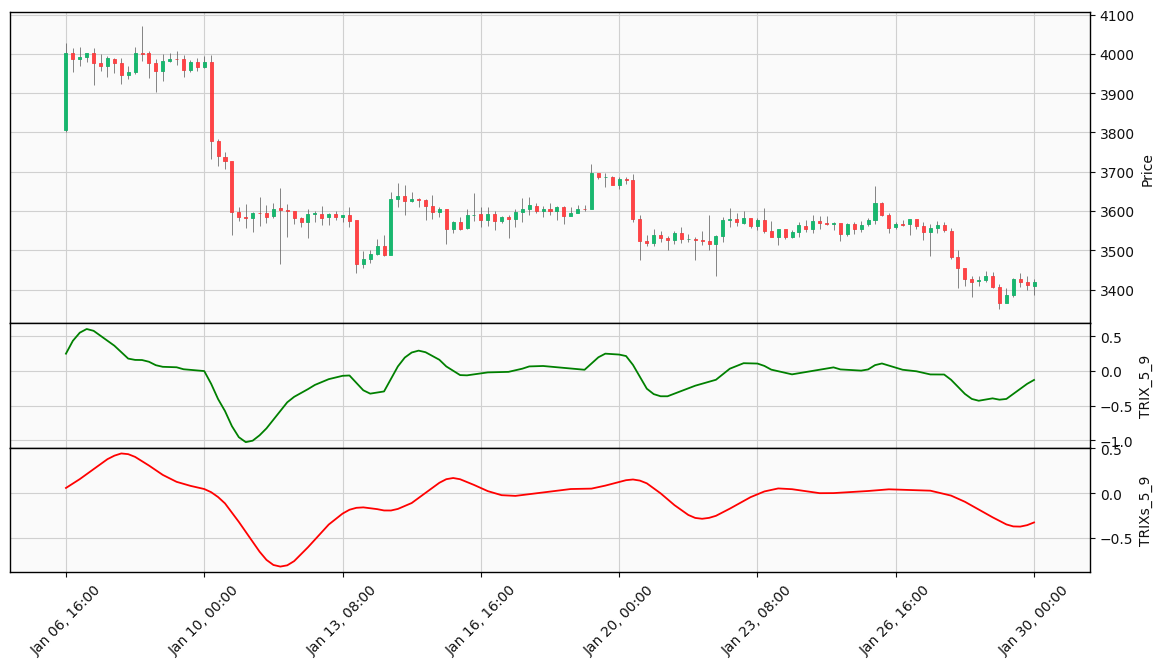

,open,high,low,close,volume,idx,buy,sell,TRIX_5_9,TRIXs_5_9
date,,,,,,,,,,
2019-01-06 16:00:00+00:00,3806.91,4027.71,3800.31,4002.46,14209.305339,3045,0,0,0.248387,0.057892
2019-01-06 20:00:00+00:00,4001.41,4015.00,3953.53,3987.60,6248.443225,3046,0,0,0.433624,0.101193
2019-01-07 00:00:00+00:00,3987.62,4017.90,3970.03,3992.26,5364.752293,3047,0,0,0.550373,0.156581
2019-01-07 04:00:00+00:00,3991.69,4001.77,3980.08,4001.00,3600.310348,3048,0,0,0.603347,0.215593
2019-01-07 08:00:00+00:00,4001.02,4015.00,3921.53,3976.76,9056.590079,3049,0,0,0.577197,0.274273
...,...,...,...,...,...,...,...,...,...,...
2019-01-29 08:00:00+00:00,3366.63,3403.23,3364.50,3385.32,5246.122475,3181,0,0,-0.402921,-0.348554
2019-01-29 12:00:00+00:00,3385.34,3428.27,3381.00,3426.62,5798.725491,3182,0,0,-0.327082,-0.370760
2019-01-29 16:00:00+00:00,3426.15,3442.00,3405.61,3419.44,4364.293722,3183,0,0,-0.246831,-0.372842


In [34]:
def get_indicators_dict(df_in) -> dict:
    from collections import deque

    default_cols = ["date", "open", "high", "low", "close", "volume", "buy", "sell", "idx"]
    cols = [str(it) for it in df_in.columns if str(it) not in default_cols]
    print("Indicators:", cols)

    colors = deque(["red", "green", "blue", "orange", "red", "green", "blue", "orange", "red", "green"])
    indicators = {}
    used_panels = 0

    for col in cols:
        # Check if it follows price
        follow_price = abs(df_in[col][-1] / df_in["close"][-1] - 1) < 0.5
        to_add = {"panel": 0, "color": colors.pop(), "type": "line"}
        if not follow_price:
            used_panels += 1
            to_add["panel"] = used_panels
        
        indicators[col] = to_add
    
    return indicators


df_onepair = df_load.copy()[:20000]

# NOTE: Start populate your indicator here
# Example: df_onepair.ta.cmo(length=99, append=True)
df_onepair.ta.trix(length=5, append=True)


# Automatically get indicator columns and determine the panel
ind = get_indicators_dict(df_onepair)
df_onepair = get_middle(df_onepair, random.randint(1000, 4000), 70)
plot(df_onepair, ind, draw_signals=False)

display(df_onepair)

In [11]:
df_ = pd.DataFrame()
df_.ta.indicators()
help(pta.su)

Pandas TA - Technical Analysis Indicators - v0.3.2b0
Total Indicators & Utilities: 231
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bollinger_bands, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, chopiness, cksp, cmf, cmo, coppock, cross, cross_value, crossed, crossed_above, crossed_below, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, heikinashi, hilo, hl2, hlc3, hma, hull_moving_average, hwc, hwma, ibs, ichimoku, implied_volatility, increasing, inertia, kama, kc, kdj, keltner_channel, kst, kurtosis, kvo, linreg, log_return, log_returns, long_run, macd, mad, massi, mcgd, median, mfi, mid_price, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, returns, rma, roc, rolling_max, rolling_mean, rolling_min, rolling_std, rolling_vw

AttributeError: module 'pandas_ta' has no attribute 'su'

In [25]:
# Pandas TA strategies
df = df_load.copy()[:5000]

# Create your own Custom Strategy

CustomStrategy = pta.Strategy(
    name="Momo and Volatility",
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 200},
        {"kind": "bbands", "length": 20},
        {"kind": "rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},
    ]
)
# To run your "Custom Strategy"
df.ta.cores = 14
df.ta.strategy(CustomStrategy, verbose=True)
df

[+] Strategy: Momo and Volatility
[i] Indicator arguments: {'append': True}
[i] Multiprocessing 6 indicators with 13 chunks and 14/16 cpus.
[i] Total indicators: 6
[i] Columns added: 12
[i] Last Run: Saturday August 28, 2021, NYSE: 15:13:24, Local: 19:13:24 SE Asia Standard Time, Day 240/365 (66.00%)


,open,high,low,close,volume,idx,buy,sell,SMA_50,SMA_200,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20
date,,,,,,,,,,,,,,,,,,,,
2018-10-18 12:30:00+00:00,6719.99,6722.00,6712.00,6722.00,319.165441,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 12:45:00+00:00,6722.00,6725.00,6713.01,6717.41,415.551896,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 13:00:00+00:00,6718.94,6724.42,6715.00,6719.99,272.932829,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 13:15:00+00:00,6719.99,6723.43,6703.33,6710.05,244.234848,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 13:30:00+00:00,6708.11,6718.48,6708.10,6714.00,174.064040,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-09 13:15:00+00:00,3442.79,3450.00,3440.04,3446.55,245.698774,4995,0,0,3428.5180,3398.31590,3400.001712,3432.3075,3464.613288,1.882453,0.720433,55.152266,6.959455,1.752387,5.207068,335.383291
2018-12-09 13:30:00+00:00,3446.55,3503.00,3442.69,3487.01,869.874964,4996,0,0,3429.8404,3398.72880,3394.964622,3435.0985,3475.232378,2.336694,1.146729,65.408381,12.280606,5.658830,6.621776,370.283643
2018-12-09 13:45:00+00:00,3487.01,3490.00,3473.42,3488.55,624.893692,4997,0,0,3431.0988,3399.18345,3392.154033,3438.2460,3484.337967,2.681133,1.045692,65.729629,15.997165,7.500311,8.496853,391.265480
